<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/cursivetransformer_mech_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-5dyhu6ms
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-5dyhu6ms
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for circuitsvis: filename=circuitsvis-0.0.0-py3-none-any.whl size=6172334 sha256=59415c32edc93016c6c42f3b4833706a3be43b700e7573be5495cc7c0ec5f306
  Stored in directory: /tmp/pip-ephem-wheel-cache-xv7_jlcy/wheels/86/be/ad/78078aba9344d200aad61b63d35cdaecdec160212f039eed74
Successfully built circuitsvis
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.4.0
    Uninstalling importlib_metadata-8.4.0:
      Successfully uninstalled importlib_metadata-8.4.0
ERROR: 

In [92]:
import os
import sys; sys.path.append('/content/cursivetransformer');
import copy
import types
from typing import List, Callable, Dict, Optional, Union
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import circuitsvis as cv

from IPython.display import display
from jaxtyping import Float, Int

from cursivetransformer.model import get_all_args, get_checkpoint, get_latest_checkpoint_artifact
from cursivetransformer.data import create_datasets, offsets_to_strokes, strokes_to_offsets
from cursivetransformer.sample import generate, generate_n_words, plot_strokes
from cursivetransformer.mech_interp import (
    HookedCursiveTransformer,
    HookedCursiveTransformerConfig,
    convert_cursivetransformer_model_config,
    visualize_attention
)

import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint

# Saves computation time, since we don't need it for the contents of this notebook
torch.set_grad_enabled(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import wandb
wandb.login()

wandb: Currently logged in as: zwimpee (llm-lab). Use `wandb login --relogin` to force relogin


True

In [ ]:
args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'  # Replace with your actual run ID
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'  # Replace with your dataset name
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

Trying to load dataset file from /content/cursivetransformer/data/bigbank.json.zip
Succeeded in loading the bigbank dataset; contains 1900 items.
For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples


In [5]:
cfg = convert_cursivetransformer_model_config(args)
model = HookedCursiveTransformer.from_pretrained("cursivetransformer", cfg)

Loading pretrained model cursivetransformer
Finding latest checkpoint for W&B run id 6le6tujz
  model:best_checkpoint:v70
  model:best_checkpoint:v71
  model:best_checkpoint:v72
  model:best_checkpoint:v73
  model:best_checkpoint:v74
  model:best_checkpoint:v75
  model:best_checkpoint:v76
  model:best_checkpoint:v77
  model:best_checkpoint:v78
  model:best_checkpoint:v79
  model:best_checkpoint:v80
  model:best_checkpoint:v81
  model:best_checkpoint:v82
  model:best_checkpoint:v83
  model:best_checkpoint:v84
  model:best_checkpoint:v85
  model:best_checkpoint:v86
  model:best_checkpoint:v87
  model:best_checkpoint:v88
  model:best_checkpoint:v89
  wandb-history:run-6le6tujz-history:v4
Selected:  model:best_checkpoint:v89


wandb:   1 of 1 files downloaded.  


Successfully loaded pretrained model cursivetransformer


# Induction Circuit Investigation and Analysis

## 1. Get an example from the dataset and create repeated pattern

In [6]:
batch_size = 10
index = 0
x, c, y = test_dataset[index]
x = x.unsqueeze(0) # Shape: [1, 1000]
c = c.unsqueeze(0) # Shape: [1, 50]
y = y.unsqueeze(0) # Shape: [1, 1000]

### Create repeated sequence of stroke and ascii tokens (super hacky, not scalable at all really)

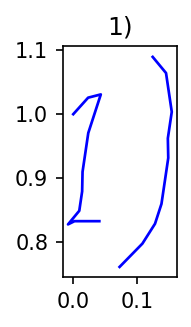

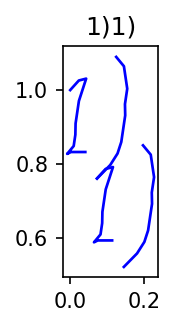

In [134]:
stroke_sequence = x[0][:50]
ascii_sequence = c[0][:2]

repeated_stroke_sequence = torch.cat((stroke_sequence, torch.tensor(test_dataset.PAD_TOKEN).unsqueeze(0), stroke_sequence)).unsqueeze(0)
repeated_ascii_sequence = einops.repeat(ascii_sequence, "seq_len -> (2 seq_len)")

# - [x] TODO: FIX THIS!
_ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(stroke_sequence)), test_dataset.decode_text(ascii_sequence))
_ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(repeated_stroke_sequence)), test_dataset.decode_text(repeated_ascii_sequence))

## 2. Run the model over the input token sequences

In [135]:
repeated_ascii_sequence = repeated_ascii_sequence.unsqueeze(0)

with torch.no_grad():
    outputs, cache = model.run_with_cache(
        repeated_stroke_sequence, repeated_ascii_sequence,
        return_type="both", per_token_loss=True
    )

## 3. Compute and plot per-token loss by position

In [136]:
loss_by_position = outputs[1].detach().cpu().numpy()  # Shape: [batch_size, sequence_length]
px.line(y=loss_by_position[0], labels={"x": "Position", "y": "Loss"}, title="Loss by position on repeated token sequence").show()

# TODO

Adapted from https://colab.research.google.com/drive/1TVHaqN7if-8aCmc06t8CAIaHUlhJ4ek7?usp=sharing

In [ ]:
import re

import einops
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import torch as t
from jaxtyping import Float
from plotly.subplots import make_subplots
from torch import Tensor

def get_log_probs(
    logits: Float[Tensor, "batch posn d_vocab"], tokens: Int[Tensor, "batch posn"]
) -> Float[Tensor, "batch posn-1"]:
    log_probs = logits.log_softmax(dim=-1)
    # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
    log_probs_for_tokens = (
        log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)
    )

    return log_probs_for_tokens

def to_numpy(tensor):
    """
    Helper function to convert a tensor to a numpy array. Also works on lists, tuples, and numpy arrays.
    """
    if isinstance(tensor, np.ndarray):
        return tensor
    elif isinstance(tensor, (list, tuple)):
        array = np.array(tensor)
        return array
    elif isinstance(tensor, (t.Tensor, t.nn.parameter.Parameter)):
        return tensor.detach().cpu().numpy()
    elif isinstance(tensor, (int, float, bool, str)):
        return np.array(tensor)
    else:
        raise ValueError(f"Input to to_numpy has invalid type: {type(tensor)}")


# GENERIC PLOTTING FUNCTIONS

update_layout_set = {
    "xaxis_range",
    "yaxis_range",
    "hovermode",
    "xaxis_title",
    "yaxis_title",
    "colorbar",
    "colorscale",
    "coloraxis",
    "title_x",
    "bargap",
    "bargroupgap",
    "xaxis_tickformat",
    "yaxis_tickformat",
    "title_y",
    "legend_title_text",
    "xaxis_showgrid",
    "xaxis_gridwidth",
    "xaxis_gridcolor",
    "yaxis_showgrid",
    "yaxis_gridwidth",
    "yaxis_gridcolor",
    "showlegend",
    "xaxis_tickmode",
    "yaxis_tickmode",
    "margin",
    "xaxis_visible",
    "yaxis_visible",
    "bargap",
    "bargroupgap",
    "coloraxis_showscale",
    "xaxis_tickangle",
    "yaxis_scaleanchor",
    "xaxis_tickfont",
    "yaxis_tickfont",
}

update_traces_set = {"textposition"}


def imshow(tensor: t.Tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if ("size" in kwargs_pre) or ("shape" in kwargs_pre):
        size = kwargs_pre.pop("size", None) or kwargs_pre.pop("shape", None)
        kwargs_pre["height"], kwargs_pre["width"] = size  # type: ignore
    facet_labels = kwargs_pre.pop("facet_labels", None)
    border = kwargs_pre.pop("border", False)
    return_fig = kwargs_pre.pop("return_fig", False)
    text = kwargs_pre.pop("text", None)
    xaxis_tickangle = kwargs_post.pop("xaxis_tickangle", None)
    # xaxis_tickfont = kwargs_post.pop("xaxis_tickangle", None)
    static = kwargs_pre.pop("static", False)
    if "color_continuous_scale" not in kwargs_pre:
        kwargs_pre["color_continuous_scale"] = "RdBu"
    if "color_continuous_midpoint" not in kwargs_pre:
        kwargs_pre["color_continuous_midpoint"] = 0.0
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    fig = px.imshow(to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post)
    if facet_labels:
        # Weird thing where facet col wrap means labels are in wrong order
        if "facet_col_wrap" in kwargs_pre:
            facet_labels = reorder_list_in_plotly_way(facet_labels, kwargs_pre["facet_col_wrap"])
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]["text"] = label  # type: ignore
    if border:
        fig.update_xaxes(showline=True, linewidth=1, linecolor="black", mirror=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor="black", mirror=True)
    if text:
        if tensor.ndim == 2:
            # if 2D, then we assume text is a list of lists of strings
            assert isinstance(text[0], list)
            assert isinstance(text[0][0], str)
            text = [text]
        else:
            # if 3D, then text is either repeated for each facet, or different
            assert isinstance(text[0], list)
            if isinstance(text[0][0], str):
                text = [text for _ in range(len(fig.data))]
        for i, _text in enumerate(text):
            fig.data[i].update(text=_text, texttemplate="%{text}", textfont={"size": 12})
    # Very hacky way of fixing the fact that updating layout with xaxis_* only applies to first facet by default
    if xaxis_tickangle is not None:
        n_facets = 1 if tensor.ndim == 2 else tensor.shape[0]
        for i in range(1, 1 + n_facets):
            xaxis_name = "xaxis" if i == 1 else f"xaxis{i}"
            fig.layout[xaxis_name]["tickangle"] = xaxis_tickangle  # type: ignore
    return fig if return_fig else fig.show(renderer=renderer, config={"staticPlot": static})


def reorder_list_in_plotly_way(L: list, col_wrap: int):
    """
    Helper function, because Plotly orders figures in an annoying way when there's column wrap.
    """
    L_new = []
    while len(L) > 0:
        L_new.extend(L[-col_wrap:])
        L = L[:-col_wrap]
    return L_new


def line(y: t.Tensor | list, renderer=None, **kwargs):
    """
    Edit to this helper function, allowing it to take args in update_layout (e.g. yaxis_range).
    """
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if ("size" in kwargs_pre) or ("shape" in kwargs_pre):
        size = kwargs_pre.pop("size", None) or kwargs_pre.pop("shape", None)
        kwargs_pre["height"], kwargs_pre["width"] = size  # type: ignore
    return_fig = kwargs_pre.pop("return_fig", False)
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    if "xaxis_tickvals" in kwargs_pre:
        tickvals = kwargs_pre.pop("xaxis_tickvals")
        kwargs_post["xaxis"] = dict(
            tickmode="array",
            tickvals=kwargs_pre.get("x", np.arange(len(tickvals))),
            ticktext=tickvals,
        )
    if "hovermode" not in kwargs_post:
        kwargs_post["hovermode"] = "x unified"
    if "use_secondary_yaxis" in kwargs_pre and kwargs_pre["use_secondary_yaxis"]:
        del kwargs_pre["use_secondary_yaxis"]
        if "labels" in kwargs_pre:
            labels: dict = kwargs_pre.pop("labels")
            kwargs_post["yaxis_title_text"] = labels.get("y1", None)
            kwargs_post["yaxis2_title_text"] = labels.get("y2", None)
            kwargs_post["xaxis_title_text"] = labels.get("x", None)
        for k in ["title", "template", "width", "height"]:
            if k in kwargs_pre:
                kwargs_post[k] = kwargs_pre.pop(k)
        fig = make_subplots(specs=[[{"secondary_y": True}]]).update_layout(**kwargs_post)
        y0 = to_numpy(y[0])
        y1 = to_numpy(y[1])
        x0, x1 = kwargs_pre.pop("x", [np.arange(len(y0)), np.arange(len(y1))])
        name0, name1 = kwargs_pre.pop("names", ["yaxis1", "yaxis2"])
        fig.add_trace(go.Scatter(y=y0, x=x0, name=name0), secondary_y=False)
        fig.add_trace(go.Scatter(y=y1, x=x1, name=name1), secondary_y=True)
    else:
        y = (
            list(map(to_numpy, y))
            if isinstance(y, list) and not (isinstance(y[0], int) or isinstance(y[0], float))
            else to_numpy(y)
        )  # type: ignore
        names = kwargs_pre.pop("names", None)
        fig = px.line(y=y, **kwargs_pre).update_layout(**kwargs_post)
        if names is not None:
            fig.for_each_trace(lambda trace: trace.update(name=names.pop(0)))
    return fig if return_fig else fig.show(renderer=renderer)


def scatter(x, y, renderer=None, **kwargs):
    x = to_numpy(x)
    y = to_numpy(y)
    add_line = None
    if "add_line" in kwargs:
        add_line = kwargs.pop("add_line")
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_traces = {k: v for k, v in kwargs.items() if k in update_traces_set}
    kwargs_pre = {
        k: v for k, v in kwargs.items() if k not in (update_layout_set | update_traces_set)
    }
    if ("size" in kwargs_pre) or ("shape" in kwargs_pre):
        size = kwargs_pre.pop("size", None) or kwargs_pre.pop("shape", None)
        kwargs_pre["height"], kwargs_pre["width"] = size  # type: ignore
    return_fig = kwargs_pre.pop("return_fig", False)
    facet_labels = kwargs_pre.pop("facet_labels", None)
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    fig = px.scatter(y=y, x=x, **kwargs_pre).update_layout(**kwargs_post)
    if add_line is not None:
        xrange = fig.layout.xaxis.range or [x.min(), x.max()]  # type: ignore
        yrange = fig.layout.yaxis.range or [y.min(), y.max()]  # type: ignore
        add_line = add_line.replace(" ", "")
        if add_line in ["x=y", "y=x"]:
            fig.add_trace(go.Scatter(mode="lines", x=xrange, y=xrange, showlegend=False))
        elif re.match("(x|y)=", add_line):
            try:
                c = float(add_line.split("=")[1])
            except:
                raise ValueError(
                    f"Unrecognized add_line: {add_line}. Please use either 'x=y' or 'x=c' or 'y=c' for some float c."
                )
            x, y = ([c, c], yrange) if add_line[0] == "x" else (xrange, [c, c])
            fig.add_trace(go.Scatter(mode="lines", x=x, y=y, showlegend=False))
        else:
            raise ValueError(
                f"Unrecognized add_line: {add_line}. Please use either 'x=y' or 'x=c' or 'y=c' for some float c."
            )
    if facet_labels:
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]["text"] = label  # type: ignore
    fig.update_traces(**kwargs_traces)
    return fig if return_fig else fig.show(renderer=renderer)


def bar(tensor, renderer=None, **kwargs):
    """ """
    if isinstance(tensor, list):
        if isinstance(tensor[0], t.Tensor):
            arr = [to_numpy(tn) for tn in tensor]
        elif isinstance(tensor[0], list):
            arr = [np.array(tn) for tn in tensor]
        else:
            arr = np.array(tensor)
    else:
        arr = to_numpy(tensor)
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    return_fig = kwargs_pre.pop("return_fig", False)
    names = kwargs_pre.pop("names", None)
    if "hovermode" not in kwargs_post:
        kwargs_post["hovermode"] = "x unified"
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    fig = px.bar(y=arr, **kwargs_pre).update_layout(**kwargs_post)
    if names is not None:
        for i in range(len(fig.data)):
            fig.data[i]["name"] = names[i // 2 if "marginal" in kwargs_pre else i]
    return fig if return_fig else fig.show(renderer=renderer)


def hist(tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    # draw = kwargs_pre.pop("draw", True)
    # static = kwargs_pre.pop("static", False)
    return_fig = kwargs_pre.pop("return_fig", False)
    if isinstance(tensor, list):
        if isinstance(tensor[0], t.Tensor):
            arr = [to_numpy(tn) for tn in tensor]
        elif isinstance(tensor[0], list):
            arr = [np.array(tn) for tn in tensor]
        else:
            arr = np.array(tensor)
    else:
        arr = to_numpy(tensor)
    if "modebar_add" not in kwargs_post:
        kwargs_post["modebar_add"] = [
            "drawline",
            "drawopenpath",
            "drawclosedpath",
            "drawcircle",
            "drawrect",
            "eraseshape",
        ]
    add_mean_line = kwargs_pre.pop("add_mean_line", False)
    names = kwargs_pre.pop("names", None)
    if "barmode" not in kwargs_post:
        kwargs_post["barmode"] = "overlay"
    if "bargap" not in kwargs_post:
        kwargs_post["bargap"] = 0.0
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    if "hovermode" not in kwargs_post:
        kwargs_post["hovermode"] = "x unified"
    if "autosize" not in kwargs_post:
        kwargs_post["autosize"] = False

    # If `arr` has a list of arrays, then just doing px.histogram doesn't work annoyingly enough
    # This is janky, even for my functions!
    if isinstance(arr, list) and isinstance(arr[0], np.ndarray):
        assert "marginal" not in kwargs_pre, "Can't use `marginal` with a list of arrays"
        for thing_to_move_from_pre_to_post in ["title", "template", "height", "width", "labels"]:
            if thing_to_move_from_pre_to_post in kwargs_pre:
                kwargs_post[thing_to_move_from_pre_to_post] = kwargs_pre.pop(
                    thing_to_move_from_pre_to_post
                )
        if "labels" in kwargs_post:
            kwargs_post["xaxis_title_text"] = kwargs_post["labels"].get("x", "")
            kwargs_post["yaxis_title_text"] = kwargs_post["labels"].get("y", "")
            del kwargs_post["labels"]
        fig = go.Figure(layout=go.Layout(**kwargs_post))
        if "nbins" in kwargs_pre:
            kwargs_pre["nbinsx"] = int(kwargs_pre.pop("nbins"))
        for x in arr:
            fig.add_trace(
                go.Histogram(x=x, name=names.pop(0) if names is not None else None, **kwargs_pre)
            )
    else:
        fig = px.histogram(x=arr, **kwargs_pre).update_layout(**kwargs_post)
        if names is not None:
            for i in range(len(fig.data)):
                fig.data[i]["name"] = names[i // 2 if "marginal" in kwargs_pre else i]

    assert isinstance(arr, (np.ndarray, Tensor))

    if add_mean_line:
        if arr.ndim == 1:
            fig.add_vline(
                x=arr.mean(),
                line_width=3,
                line_dash="dash",
                line_color="black",
                annotation_text=f"Mean = {arr.mean():.3f}",
                annotation_position="top",
            )
        elif arr.ndim == 2:
            for i in range(arr.shape[0]):
                fig.add_vline(
                    x=arr[i].mean(),
                    line_width=3,
                    line_dash="dash",
                    line_color="black",
                    annotation_text=f"Mean = {arr.mean():.3f}",
                    annotation_position="top",
                )
    return fig if return_fig else fig.show(renderer=renderer)


# PLOTTING FUNCTIONS FOR PART 2: INTRO TO MECH INTERP


def plot_comp_scores(model, comp_scores, title: str = "", baseline: t.Tensor | None = None):
    px.imshow(
        to_numpy(comp_scores),
        y=[f"L0H{h}" for h in range(model.cfg.n_heads)],
        x=[f"L1H{h}" for h in range(model.cfg.n_heads)],
        labels={"x": "Layer 1", "y": "Layer 0"},
        title=title,
        color_continuous_scale="RdBu" if baseline is not None else "Blues",
        color_continuous_midpoint=baseline if baseline is not None else None,
        zmin=None if baseline is not None else 0.0,
    ).show()


def convert_tokens_to_string(model, tokens, batch_index=0):
    """
    Helper function to convert tokens into a list of strings, for printing.
    """
    if len(tokens.shape) == 2:
        tokens = tokens[batch_index]
    return [f"|{model.tokenizer.decode(tok)}|_{c}" for (c, tok) in enumerate(tokens)]


def plot_logit_attribution(model, logit_attr: t.Tensor, tokens: t.Tensor, title: str = ""):
    tokens = tokens.squeeze()
    y_labels = convert_tokens_to_string(model, tokens[:-1])
    x_labels = ["Direct"] + [
        f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
    ]
    imshow(
        to_numpy(logit_attr),  # type: ignore
        x=x_labels,
        y=y_labels,
        labels={"x": "Term", "y": "Position", "color": "logit"},
        title=title if title else None,
        height=18 * len(y_labels),
        width=24 * len(x_labels),
    )


# PLOTTING FUNCTIONS FOR PART 4: INTERP ON ALGORITHMIC MODEL

color_discrete_map = dict(
    zip(
        ["both failures", "just neg failure", "balanced", "just total elevation failure"],
        px.colors.qualitative.D3,
    )
)
# names = ["balanced", "just total elevation failure", "just neg failure", "both failures"]
# colors = ['#2CA02C', '#1c96eb', '#b300ff', '#ff4800']
# color_discrete_map = dict(zip(names, colors))


def plot_failure_types_scatter(
    unbalanced_component_1: Float[Tensor, "batch"],
    unbalanced_component_2: Float[Tensor, "batch"],
    failure_types_dict: dict[str, Float[Tensor, "batch"]],
    data,
):
    failure_types = np.full(len(unbalanced_component_1), "", dtype=np.dtype("U32"))
    for name, mask in failure_types_dict.items():
        failure_types = np.where(to_numpy(mask), name, failure_types)
    failures_df = pd.DataFrame(
        {
            "Head 2.0 contribution": to_numpy(unbalanced_component_1),
            "Head 2.1 contribution": to_numpy(unbalanced_component_2),
            "Failure type": to_numpy(failure_types),
        }
    )[data.starts_open.tolist()]
    fig = px.scatter(
        failures_df,
        color_discrete_map=color_discrete_map,
        x="Head 2.0 contribution",
        y="Head 2.1 contribution",
        color="Failure type",
        title="h20 vs h21 for different failure types",
        template="simple_white",
        height=600,
        width=800,
        # category_orders={"color": failure_types_dict.keys()},
    ).update_traces(marker_size=4)
    fig.show()


def plot_contribution_vs_open_proportion(
    unbalanced_component: Float[Tensor, "batch"], title: str, failure_types_dict: dict, data
):
    failure_types = np.full(len(unbalanced_component), "", dtype=np.dtype("U32"))
    for name, mask in failure_types_dict.items():
        failure_types = np.where(to_numpy(mask), name, failure_types)
    fig = (
        px.scatter(
            x=to_numpy(data.open_proportion),
            y=to_numpy(unbalanced_component),
            color=failure_types,
            color_discrete_map=color_discrete_map,
            title=title,
            template="simple_white",
            height=500,
            width=800,
            labels={"x": "Open-proportion", "y": f"Head {title} contribution"},
        )
        .update_traces(marker_size=4, opacity=0.5)
        .update_layout(legend_title_text="Failure type")
    )
    fig.show()


def mlp_attribution_scatter(
    out_by_component_in_pre_20_unbalanced_dir: Float[Tensor, "comp batch"],
    data,
    failure_types_dict: dict,
) -> None:
    failure_types = np.full(
        out_by_component_in_pre_20_unbalanced_dir.shape[-1], "", dtype=np.dtype("U32")
    )
    for name, mask in failure_types_dict.items():
        failure_types = np.where(to_numpy(mask), name, failure_types)
    for layer in range(2):
        mlp_output = out_by_component_in_pre_20_unbalanced_dir[3 + layer * 3]
        fig = (
            px.scatter(
                x=to_numpy(data.open_proportion[data.starts_open]),
                y=to_numpy(mlp_output[data.starts_open]),
                color_discrete_map=color_discrete_map,
                color=to_numpy(failure_types)[to_numpy(data.starts_open)],
                title=f"Amount MLP {layer} writes in unbalanced direction for Head 2.0",
                template="simple_white",
                height=500,
                width=800,
                labels={"x": "Open-proportion", "y": "Head 2.0 contribution"},
            )
            .update_traces(marker_size=4, opacity=0.5)
            .update_layout(legend_title_text="Failure type")
        )
        fig.show()


def plot_neurons(
    neurons_in_unbalanced_dir: Float[Tensor, "batch neurons"],
    model,
    data,
    failure_types_dict: dict,
    layer: int,
    renderer=None,
):
    failure_types = np.full(neurons_in_unbalanced_dir.shape[0], "", dtype=np.dtype("U32"))
    for name, mask in failure_types_dict.items():
        failure_types = np.where(to_numpy(mask[to_numpy(data.starts_open)]), name, failure_types)

    # Get data that can be turned into a dataframe (plotly express is sometimes easier to use with a dataframe)
    # Plot a scatter plot of all the neuron contributions, color-coded according to failure type, with slider to view neurons
    neuron_numbers = einops.repeat(
        t.arange(model.cfg.d_model), "n -> (s n)", s=data.starts_open.sum()
    )
    failure_types = einops.repeat(failure_types, "s -> (s n)", n=model.cfg.d_model)
    data_open_proportion = einops.repeat(
        data.open_proportion[data.starts_open], "s -> (s n)", n=model.cfg.d_model
    )
    df = pd.DataFrame(
        {
            "Output in 2.0 direction": to_numpy(neurons_in_unbalanced_dir.flatten()),
            "Neuron number": to_numpy(neuron_numbers),
            "Open-proportion": to_numpy(data_open_proportion),
            "Failure type": failure_types,
        }
    )
    fig = (
        px.scatter(
            df,
            x="Open-proportion",
            y="Output in 2.0 direction",
            color="Failure type",
            animation_frame="Neuron number",
            title=f"Neuron contributions from layer {layer}",
            template="simple_white",
            height=800,
            width=1100,
        )
        .update_traces(marker_size=3)
        .update_layout(xaxis_range=[0, 1], yaxis_range=[-5, 5])
    )
    fig.show(renderer=renderer)


def plot_attn_pattern(pattern: Float[Tensor, "batch head_idx seqQ seqK"]):
    fig = px.imshow(
        pattern,
        title="Estimate for avg attn probabilities when query is from '('",
        labels={
            "x": "Key tokens (avg of left & right parens)",
            "y": "Query tokens (all left parens)",
        },
        height=900,
        width=900,
        color_continuous_scale="RdBu_r",
        range_color=[0, pattern.max().item()],
    ).update_layout(
        xaxis=dict(
            tickmode="array",
            ticktext=["[start]", *[f"{i+1}" for i in range(40)], "[end]"],
            tickvals=list(range(42)),
            tickangle=0,
        ),
        yaxis=dict(
            tickmode="array",
            ticktext=["[start]", *[f"{i+1}" for i in range(40)], "[end]"],
            tickvals=list(range(42)),
        ),
    )
    fig.show()


def hists_per_comp(
    out_by_component_in_unbalanced_dir: Float[Tensor, "component batch"], data, xaxis_range=(-1, 1)
):
    """
    Plots the contributions in the unbalanced direction, as supplied by the `out_by_component_in_unbalanced_dir` tensor.
    """
    titles = {
        (1, 1): "embeddings",
        (2, 1): "head 0.0",
        (2, 2): "head 0.1",
        (2, 3): "mlp 0",
        (3, 1): "head `1.0`",
        (3, 2): "head `1.1`",
        (3, 3): "mlp 1",
        (4, 1): "head 2.0",
        (4, 2): "head 2.1",
        (4, 3): "mlp 2",
    }
    n_layers = out_by_component_in_unbalanced_dir.shape[0] // 3
    fig = make_subplots(rows=n_layers + 1, cols=3)
    for ((row, col), title), in_dir in zip(titles.items(), out_by_component_in_unbalanced_dir):
        fig.add_trace(
            go.Histogram(
                x=to_numpy(in_dir[data.isbal]),
                name="Balanced",
                marker_color="blue",
                opacity=0.5,
                legendgroup="1",
                showlegend=title == "embeddings",
            ),
            row=row,
            col=col,
        )
        fig.add_trace(
            go.Histogram(
                x=to_numpy(in_dir[~data.isbal]),
                name="Unbalanced",
                marker_color="red",
                opacity=0.5,
                legendgroup="2",
                showlegend=title == "embeddings",
            ),
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=title, row=row, col=col, range=xaxis_range)
    fig.update_layout(
        width=1200,
        height=250 * (n_layers + 1),
        barmode="overlay",
        legend=dict(yanchor="top", y=0.92, xanchor="left", x=0.4),
        title="Histograms of component significance",
    )
    fig.show()


def plot_loss_difference(log_probs, rep_str, seq_len):
    fig = px.line(
        to_numpy(log_probs),
        hover_name=rep_str[1:],
        title=f"Per token log prob on correct token, for sequence of length {seq_len}*2 (repeated twice)",
        labels={"index": "Sequence position", "value": "Log prob"},
    ).update_layout(showlegend=False, hovermode="x unified")
    fig.add_vrect(x0=0, x1=seq_len - 0.5, fillcolor="red", opacity=0.2, line_width=0)
    fig.add_vrect(
        x0=seq_len - 0.5, x1=2 * seq_len - 1, fillcolor="green", opacity=0.2, line_width=0
    )
    fig.show()

In [ ]:
# - [x] TODO: Install and import plotly_utils from the notebook linked above
def generate_repeated_tokens(
    model: HookedCursiveTransformer, seq_len: int, batch: int = 1
) -> Int[Tensor, "batch full_seq_len"]:
    '''
    Generates a sequence of repeated random tokens

    Outputs are:
        rep_tokens: [batch, 1+2*seq_len]
    '''
    #prefix = (torch.ones(batch, 1) * model.tokenizer.bos_token_id).long()
    rep_tokens_half = torch.randint(0, model.cfg.d_vocab, (batch, seq_len), dtype=torch.int64)
    rep_tokens = torch.cat(
        [# prefix,
          rep_tokens_half,
         rep_tokens_half
        ], dim=-1
    ).to(device)
    return rep_tokens



def run_and_cache_model_repeated_tokens(model: HookedCursiveTransformer, seq_len: int, batch: int = 1):
    '''
    Generates a sequence of repeated random tokens, and runs the model on it, returning (tokens, logits, cache)

    Should use the `generate_repeated_tokens` function above

    Outputs are:
        rep_tokens: [batch, 1+2*seq_len]
        rep_logits: [batch, 1+2*seq_len, d_vocab]
        rep_cache: The cache of the model run on rep_tokens
    '''
    rep_tokens = generate_repeated_tokens(model, seq_len, batch)
    rep_logits, rep_cache = model.run_with_cache(rep_tokens, context=torch.zeros())
    return rep_tokens, rep_logits, rep_cache


seq_len = 50
batch = 1
(rep_tokens, rep_logits, rep_cache) = run_and_cache_model_repeated_tokens(model, seq_len, batch)
rep_cache.remove_batch_dim()
rep_str = model.to_str_tokens(rep_tokens)
model.reset_hooks()
log_probs = get_log_probs(rep_logits, rep_tokens).squeeze()

print(f"Performance on the first half: {log_probs[:seq_len].mean():.3f}")
print(f"Performance on the second half: {log_probs[seq_len:].mean():.3f}")

plot_loss_difference(log_probs, rep_str, seq_len)

TypeError: HookedCursiveTransformer.forward() missing 1 required positional argument: 'context'

In [ ]:




# Store induction scores
induction_score_store = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)

def induction_score_hook(pattern: torch.Tensor, hook: HookPoint):
    induction_stripe = pattern.diagonal(dim1=-2, dim2=-1, offset=1 - stroke_sequence.shape[0])
    induction_score = einops.reduce(induction_stripe, "batch head_index position -> head_index", "mean")
    induction_score_store[hook.layer(), :] = induction_score

# Updated hook filter for both self-attention and cross-attention patterns
pattern_hook_names_filter = lambda name: name.endswith("attn.hook_pattern") or name.endswith("cross_attn.hook_pattern")

# Run with hooks to collect induction scores
_ = model.run_with_hooks(
    repeated_tokens,
    repeated_context,
    fwd_hooks=[(
        pattern_hook_names_filter,
        induction_score_hook
    )]
)

# Visualize induction score by head
px.imshow(induction_score_store.detach().cpu(), labels={"x": "Head", "y": "Layer"}, title="Induction Score by Head").show()

# Visualization of Attention Pattern
def visualize_pattern_hook(pattern: torch.Tensor, hook: HookPoint):
    display(
        cv.attention.attention_patterns(
            tokens=repeated_tokens,
            attention=pattern[0, induction_head_index, :, :][None, :, :] # Add a dummy axis, as CircuitsVis expects 3D patterns.
        )
    )

induction_head_layer = 3
induction_head_index = 1
model.run_with_hooks(
    repeated_tokens,
    repeated_context,
    fwd_hooks=[(
        'blocks.{}.cross_attn.hook_pattern'.format(induction_head_layer),
        visualize_pattern_hook
    )]
)

# Activation Patching

In [ ]:
# Activation Patching - Updated for Cross-Attention
def activation_patching(
    model: HookedCursiveTransformer,
    x_clean: torch.Tensor,
    c_clean: torch.Tensor,
    x_corrupted: torch.Tensor,
    c_corrupted: torch.Tensor,
    patching_nodes: List[str],
    patch_positions: Optional[torch.Tensor] = None,
):
    _, cache_corrupted = model.run_with_cache(x_corrupted, c_corrupted, return_type="both")

    def patching_hook(act, hook):
        act_corrupted = cache_corrupted[hook.name]
        if patch_positions is not None:
            act[:, patch_positions, :] = act_corrupted[:, patch_positions, :]
        else:
            act[:] = act_corrupted
        return act

    hooks = [(node, patching_hook) for node in patching_nodes]
    logits_patched = model.run_with_hooks(x_clean, c_clean, fwd_hooks=hooks, return_type="logits")
    return logits_patched

# Example Activation Patching
x_clean = stroke_sequence.unsqueeze(0)
c_clean = ascii_sequence.unsqueeze(0)

x_corrupted = x_clean.clone()
x_corrupted = (x_corrupted + 1) % model.cfg.d_vocab
c_corrupted = c_clean.clone()

patching_nodes = ['blocks.0.cross_attn.hook_result']
logits_patched = activation_patching(
    model,
    x_clean,
    c_clean,
    x_corrupted,
    c_corrupted,
    patching_nodes,
)

# Get predictions from patched logits
predictions_patched = logits_patched.argmax(dim=-1)

# Run the clean input without patches
logits_clean = model(x_clean, c_clean)
predictions_clean = logits_clean.argmax(dim=-1)

# Run the corrupted input without patches
logits_corrupted = model(x_corrupted, c_corrupted)
predictions_corrupted = logits_corrupted.argmax(dim=-1)

# Compare predictions
print("Clean Predictions:", predictions_clean)
print("Corrupted Predictions:", predictions_corrupted)
print("Patched Predictions:", predictions_patched)

# Visualize the strokes if applicable
_ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(stroke_sequence)), test_dataset.decode_text(ascii_sequence))
_ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(x_corrupted[0])), test_dataset.decode_text(c_corrupted[0]))